In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCam
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography import toolbox

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('image', cmap='turbo')

### TODOs:

- [ ] Implement transform between SLM and camera
- [ ] Proper padding for the desired resolution
- [ ] Fourier calibrate issues - use MRAF?
- [ ] Figure out why R2 looks better around edges -- likely an issue w/ padding.
- [ ] Overlapping tqdm bar issue
- [ ] Speed enhancements... 
- [ ] Accuracy of standard wavefront cal

### A simulated SLM

In [2]:
# Add a Gaussian amplitude profile to broaden the far-field spots w/o padding
res = (512,512)

#Build a random flatness map
dummy_slm = SimulatedSLM(res)
phase_offset = toolbox.phase.zernike_sum(dummy_slm,
    weights=(((2, 0),  5),       # Z_20
             ((2, 1), -5),       # Z_21
             ((3, 1),  5)),      # Z_31
    aperture="cropped")

# The perfect SLM
# slm = SimulatedSLM(res, bitdepth=12)

# The abberated SLM
slm = SimulatedSLM(res, phase_offset=phase_offset, amp_profile=0.2, bitdepth=12)

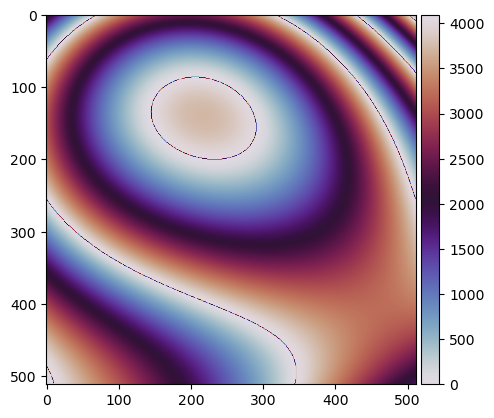

In [3]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(slm.display,
               cmap=plt.get_cmap("twilight"),
               interpolation=None)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### A simulated camera - computes the FF of simulated SLM; resamples to cam resolution w/i box given by an affine transformation

In [4]:
# TODO: coordinate transformations
cam_res = res #(1024,1024)
cam = SimulatedCam(cam_res, slm, bitdepth=12) 

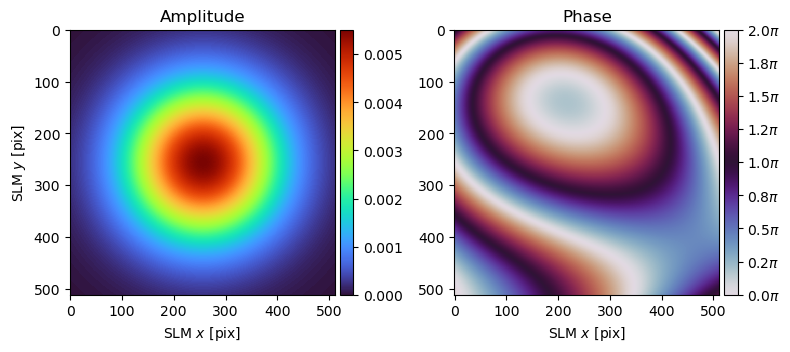

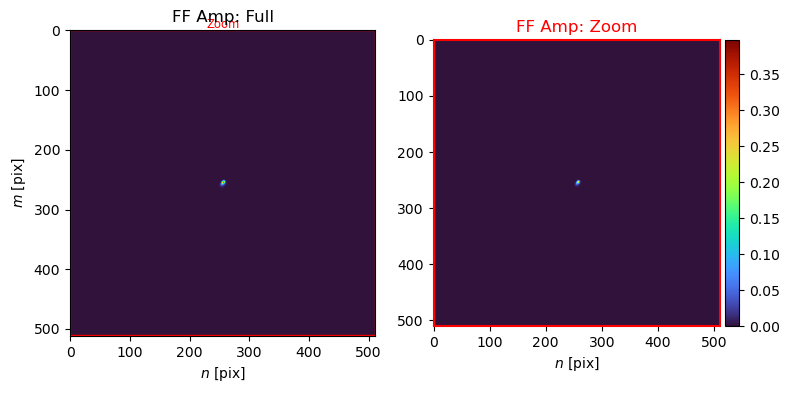

In [5]:
# %%prun #few 10s of ms to take an image -> dominated by check_nan_inf...
img = cam.get_image(plot=True)

### Wavefront calibration

In [6]:
def plot(title=""):
    _, axs = plt.subplots(1, 3, figsize=(16,4))

    if slm.phase_correction is None:
        correction = 0 * slm.phase
    else:
        correction = np.mod(slm.phase_correction, 2*np.pi)

    axs[0].set_title("Phase Correction")
    axs[0].imshow(
        correction,
        vmin=0,
        vmax=2*np.pi,
        interpolation="none",
        cmap="twilight"
    )

    axs[1].set_title("Displayed Phase")
    axs[1].imshow(
        np.mod(slm.phase, 2*np.pi),
        vmin=0,
        vmax=2*np.pi,
        interpolation="none",
        cmap="twilight"
    )

    axs[2].set_title("Camera Result")
    axs[2].imshow(cam.get_image())

    plt.suptitle(title)

    plt.show()

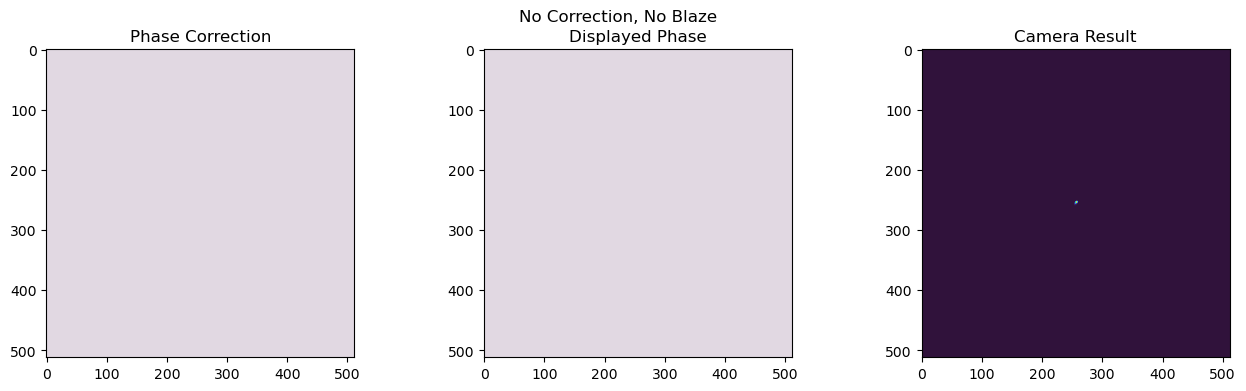

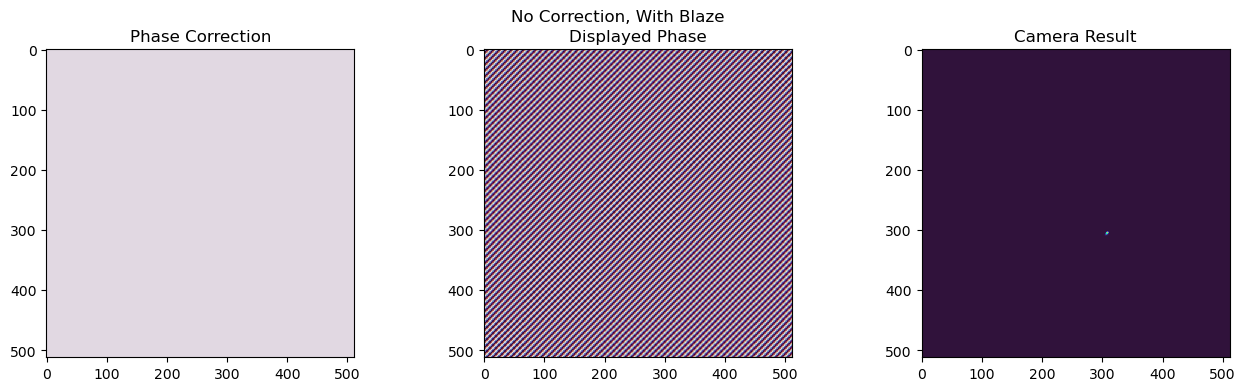

In [7]:
slm.write(None, settle=True)
plot(title="No Correction, No Blaze")

slm.write(toolbox.phase.blaze(grid=slm, vector=(0.1, 0.1)), settle=True)
plot(title="No Correction, With Blaze")

In [8]:
fs = FourierSLM(cam, slm)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 291.97it/s]


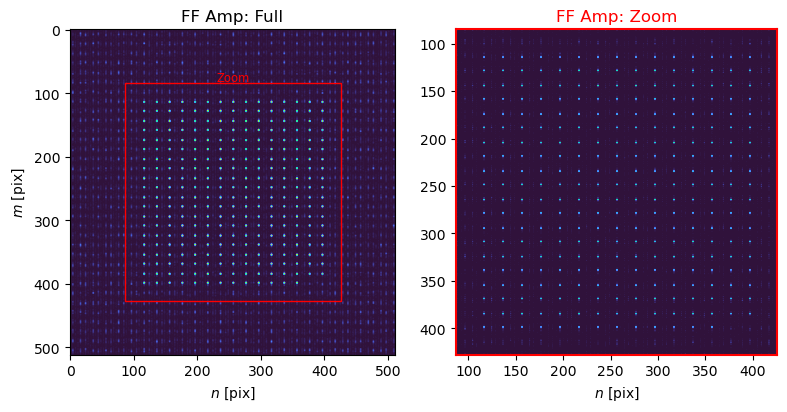

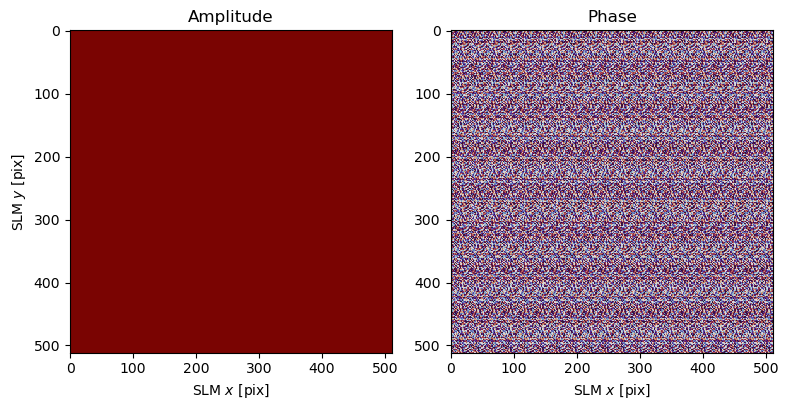

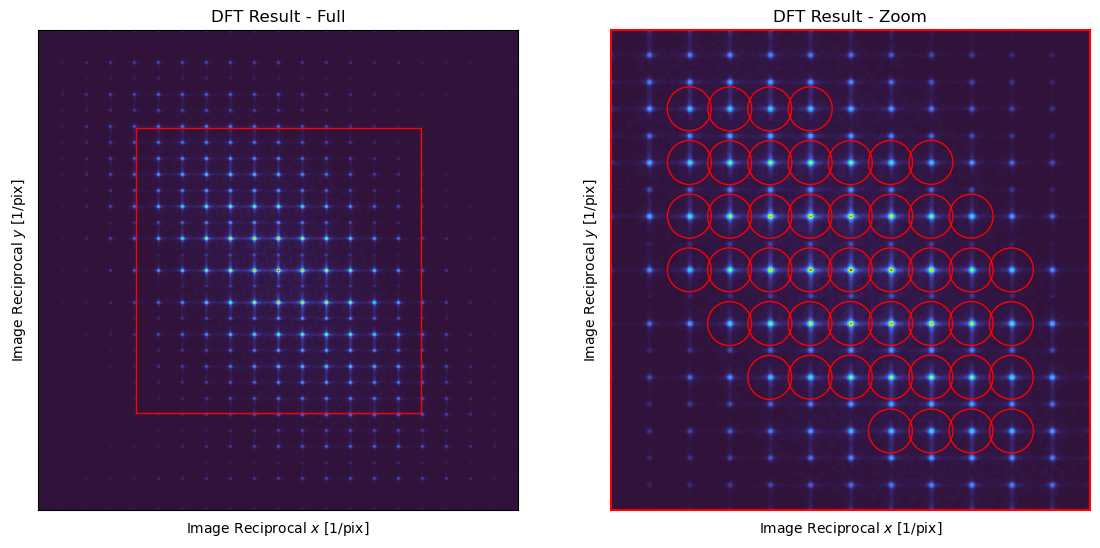

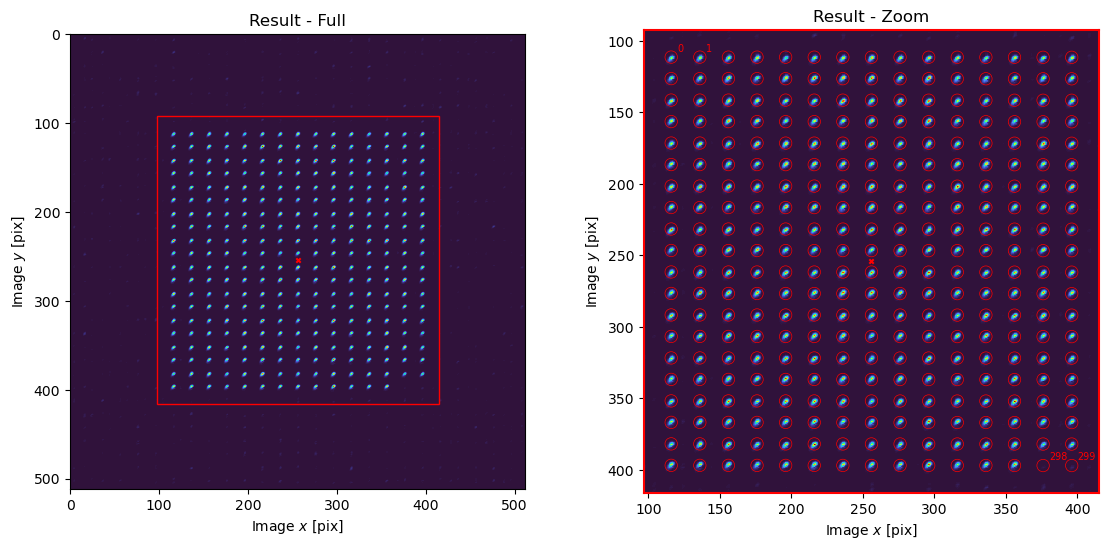

{'M': array([[5.11952330e+02, 3.29722462e-04],
        [2.49316517e-01, 5.12689601e+02]]),
 'b': array([[256.00149851],
        [254.14165553]]),
 'a': array([[0.],
        [0.]])}

In [9]:
mpl.rc('image', cmap='turbo')

# Note: sometimes failed wavefront cal for perfect SLM -- off by one; maybe use MRAF to kill edges?
fs.fourier_calibrate(
    array_shape=[15, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 15],           # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

2.0 8.891323523130268e-05
4.0 0.00017782647046260536
8.0 0.0003556529409252107
16.0 0.0007113058818504214
32.0 0.0014226117637008429
64.0 0.0028452235274016857
128.0 0.005690447054803371
256.0 0.011380894109606743
512.0 0.022761788219213486
1024.0 0.04552357643842697
2048.0 0.09104715287685394
4096.0 0.18209430575370789
8192.0 0.36418861150741577
16384.0 0.7283772230148315
32768.0 1.456754446029663
65536.0 2.913508892059326
131072.0 5.827017784118652
262144.0 11.654035568237305
524288.0 23.30807113647461
1048576.0 46.61614227294922
2097152.0 93.23228454589844
4194304.0 186.46456909179688
8388608.0 372.92913818359375
16777216.0 745.8582763671875
33554432.0 1491.716552734375
46067382.312031396 2048.0


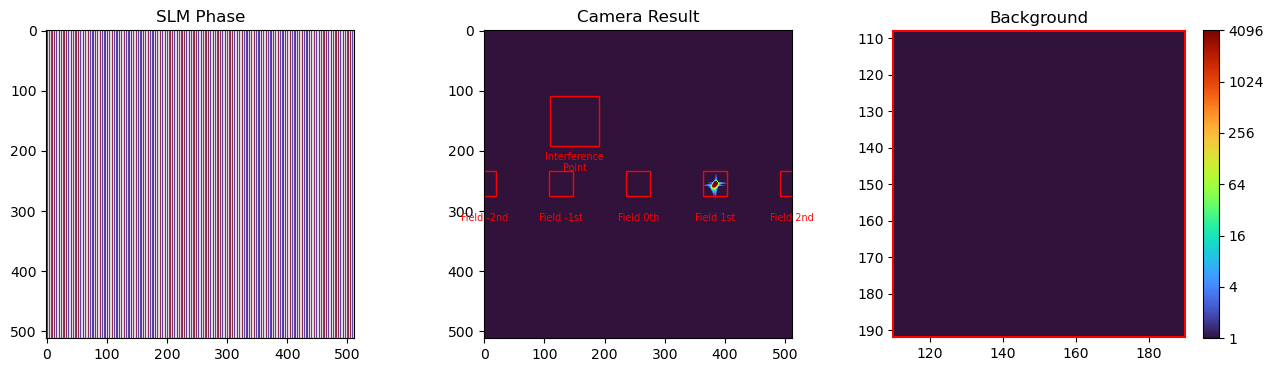

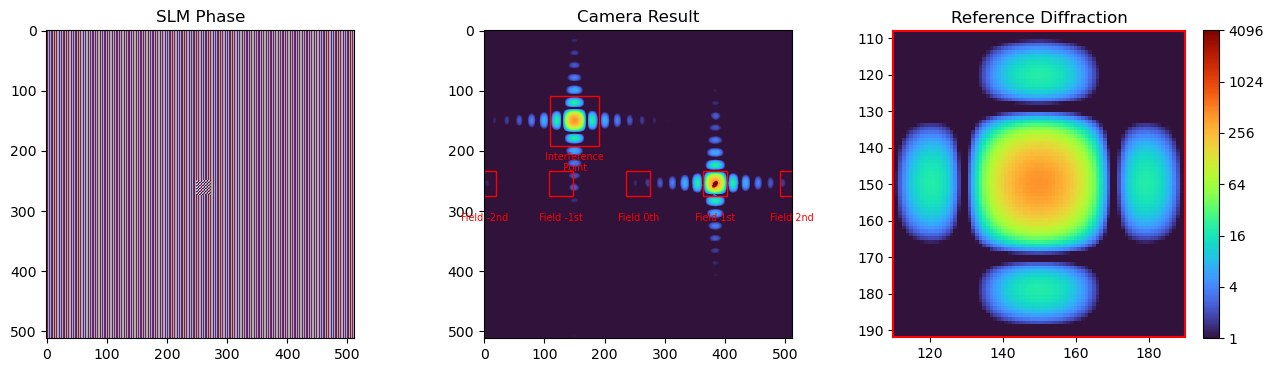

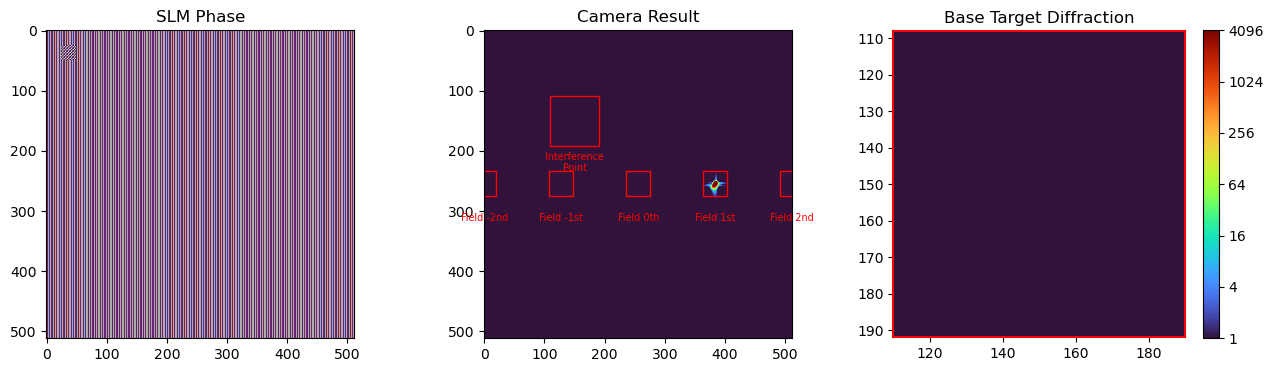

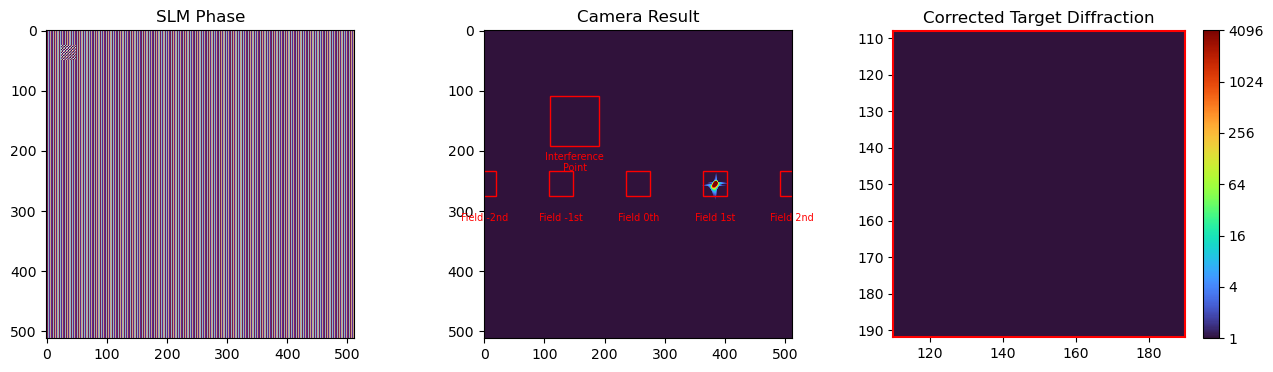

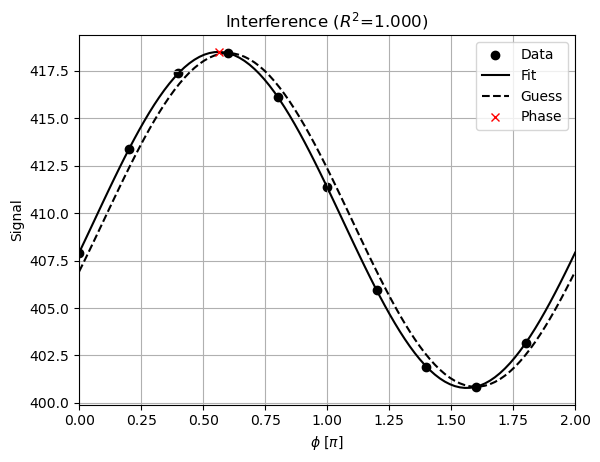

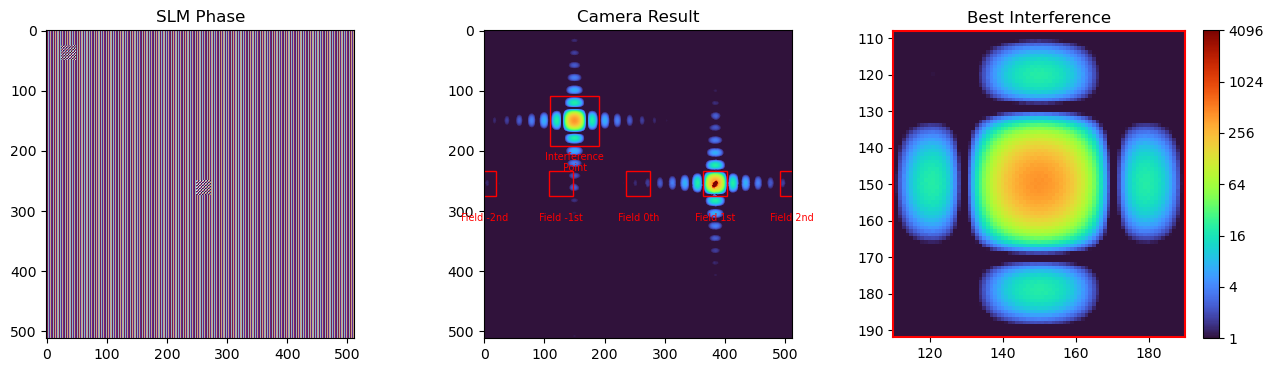

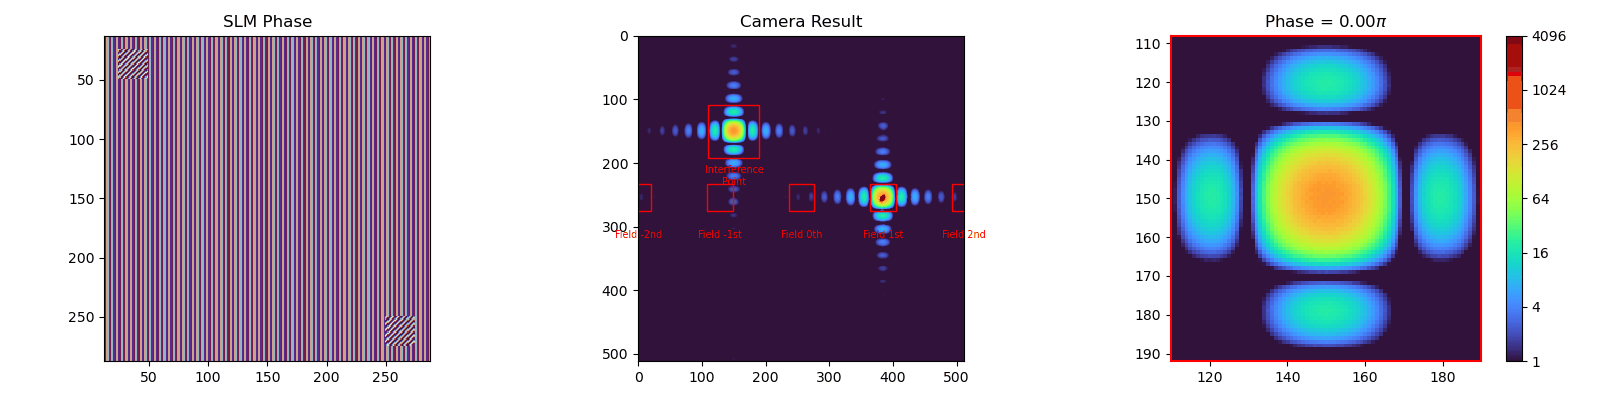

In [10]:
movie = fs.wavefront_calibrate(
    interference_point=(150, 150),
    field_point=(0.25, 0.0),
    field_point_units="freq",
    superpixel_size=25,
    test_superpixel=(1, 1),           # Testing mode
    autoexposure=True,
    plot=3                              # Special mode to generate a phase .gif
);

# Generate a phase .gif
from IPython.display import Image
import imageio
imageio.mimsave('wavefront.gif', movie)
Image(filename="wavefront.gif")

# Bad fit because no padding?

In [11]:
# %%prun
fs.wavefront_calibrate(
    interference_point=(300, 200),
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=32,
    autoexposure=True
);
# TODO: debug two TQDM bars... 

17967065.371559415 2048.000244140625


Results:

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14046  372.611    0.027  372.669    0.027 {method 'get' of 'cupy._core.core._ndarray_base' objects}
    37402  175.052    0.005  175.099    0.005 phase.py:12(blaze)
    14046  129.440    0.009  657.513    0.047 simulated.py:81(get_image)
    28052  116.172    0.004  188.371    0.007 slm.py:411(_phase2gray)
    98322  107.146    0.001  107.222    0.001 {built-in method cupy._core.core.array}
    14026   70.040    0.005  156.412    0.011 simulated.py:72(_write_hw)
612091/453053   61.831    0.000   96.191    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    79542   43.347    0.001   43.347    0.001 {built-in method numpy.array}
   115135   31.037    0.000   31.037    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      935   27.992    0.030 1193.092    1.276 cameraslms.py:972(measure)
    42138   16.017    0.000   17.851    0.000 misc.py:371(_check_nan_inf)
    
    .....

In [12]:
fs.save_wavefront_calibration()

'C:\\Users\\cpanu\\Documents\\GitHub\\slmsuite-examples\\examples\\camera-SLM-wavefront-calibration_00021.h5'

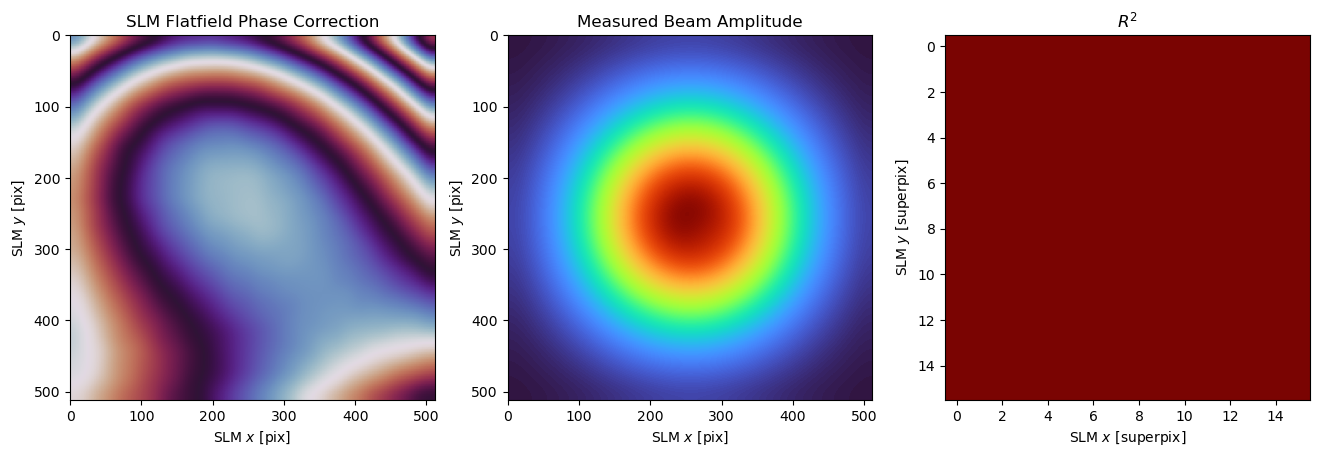

In [13]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True);

# Note: produces phase gradient even without any phase_offset on sim slm.. (very minimal)

Compare to ground truth:
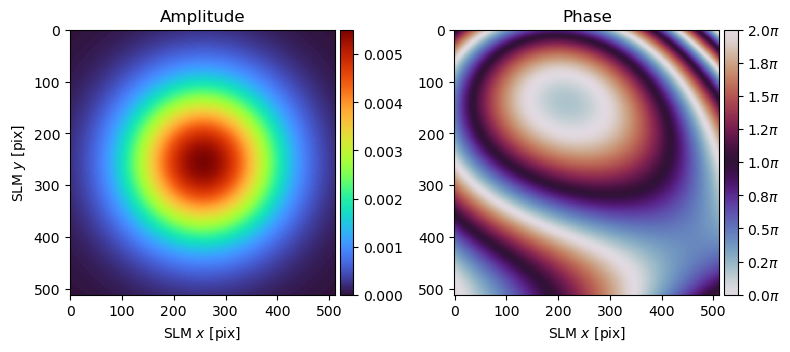